In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import Util
import linear_shrinkage
import pickle
from multiprocessing import Pool
import os
from os.path import join
import scipy.io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ret, ret_nonan, univ, tradeidx, dates = Util.load_data()

In [64]:
Ns = [5, 10]
ratios = [1, 2, 8, 32, 64, 128, 264]
Ps = [12, 36]

In [4]:
present = []
for c in range(len(ret[0])):
    col = ret[:, c]
    if np.count_nonzero(np.isnan(col)) == 0:
        present.append(c)
present = np.array(present)

In [65]:
just_OOS = False
univ_num = 2
for N in Ns:
    #get subset, save it
    subset = np.random.choice(present, size = N, replace = False)
    for r in ratios:
        T = int(r * N)
        print("Working on N = {}, T = {}".format(N, T))
        pastRets = []
        uids = []
        for h in range(len(univ)):
            pastRet = Util.get_past_period_custom_univ(h, T, subset, tradeidx, ret)
            pastRets.append(pastRet)
            uids.append(h)
        folder = "small_N_{}_T_{}_univ_{}".format(N, T, univ_num)
        if not os.path.isdir('matlab/data/{}'.format(folder)):
            os.mkdir('matlab/data/{}'.format(folder))
            pickle.dump(subset, open(join('matlab/data', folder, 'univ.pkl'), 'wb'))
        else:
            input("This folder exists...that's strange...")
        
        if not just_OOS:
            Util.populate_covs_from_samples(folder, uids, pastRets)
            Util.run_parallel_MTP2(8, folder, uids)
        
        for P in Ps:
            Util.get_MTP2_OOS_custom_univ(folder, P, subset, tradeidx, ret, P_in_name = True)
        
        if not just_OOS:
            Util.run_parallel_LS(8, folder, pastRets, uids)
        
        for P in Ps:
            Util.get_LS_OOS_custom_univ(folder, P, subset, tradeidx, ret, P_in_name = True)

Working on N = 5, T = 5
Done populating all covs
Done with running all commands!


TypeError: 'NoneType' object is not iterable

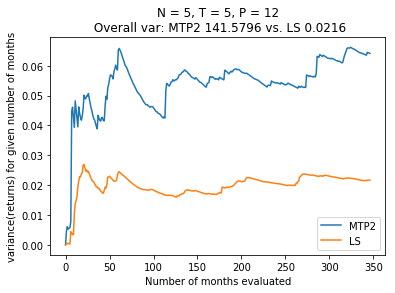

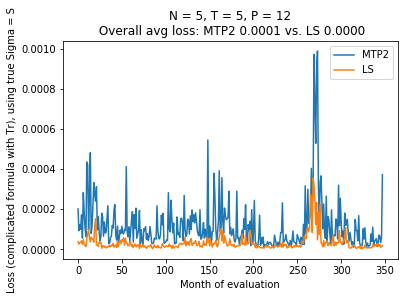

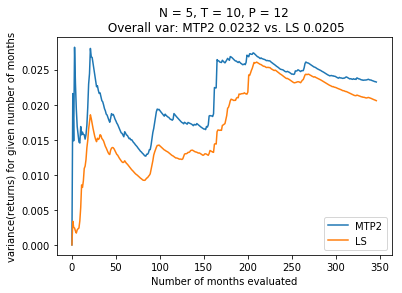

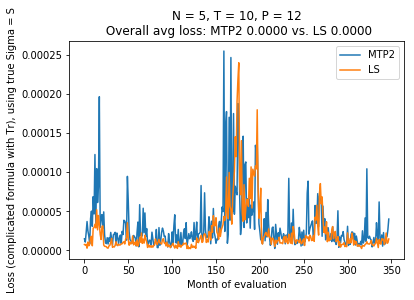

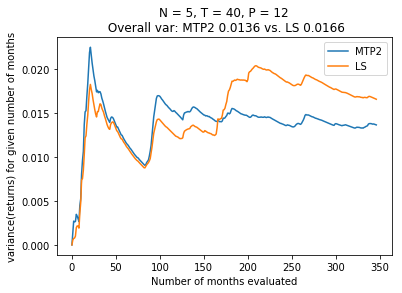

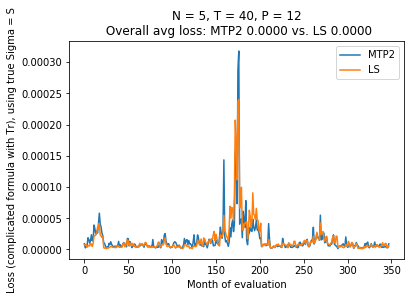

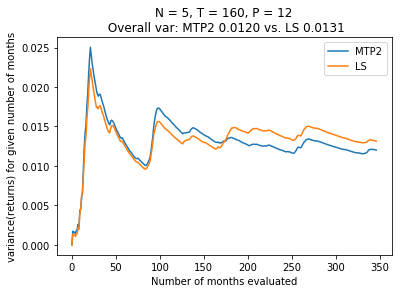

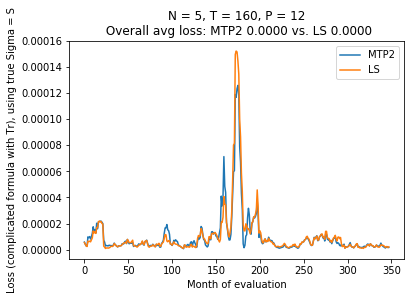

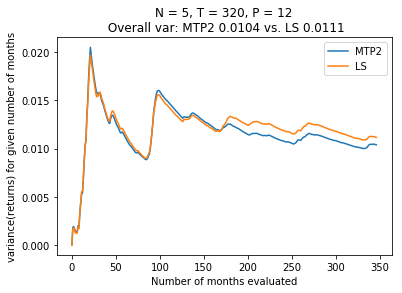

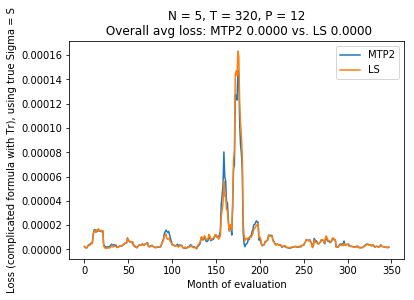

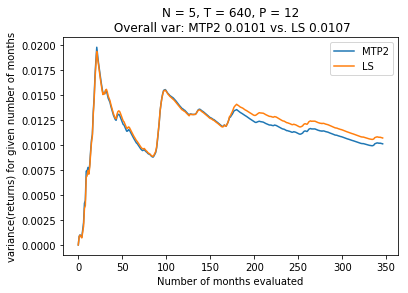

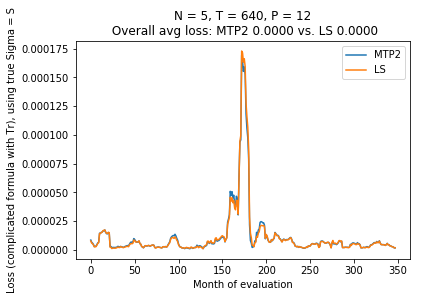

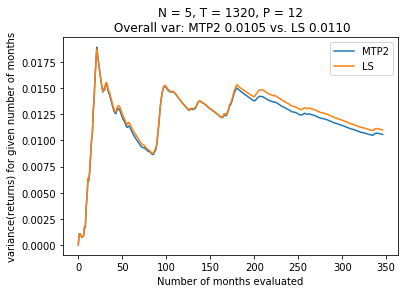

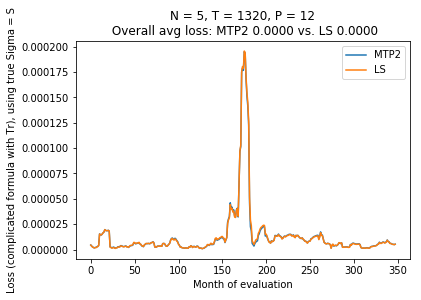

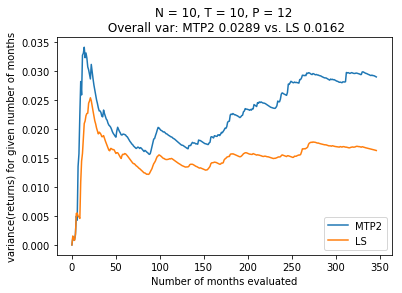

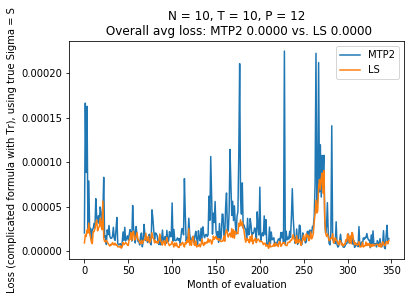

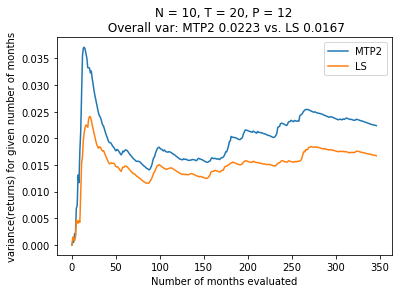

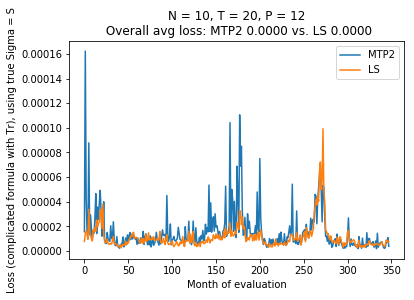

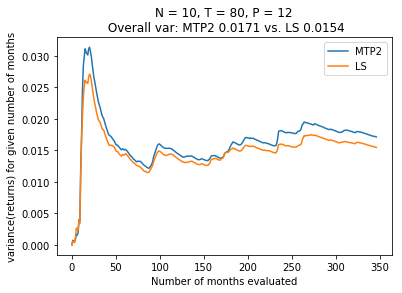

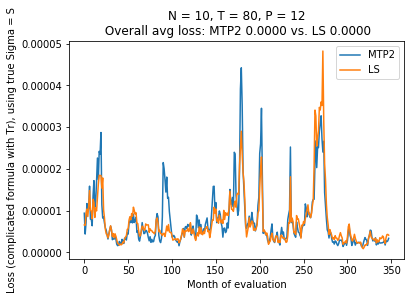

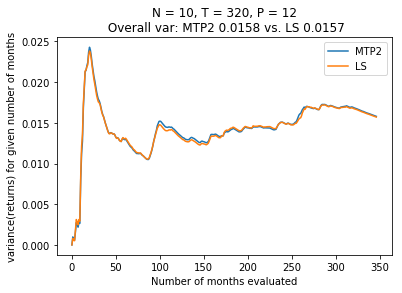

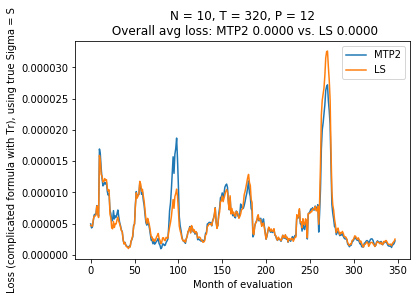

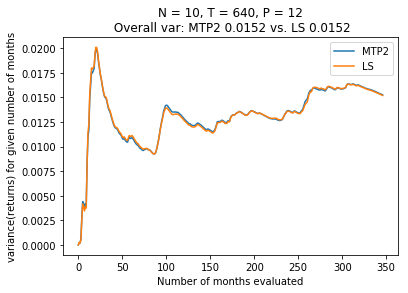

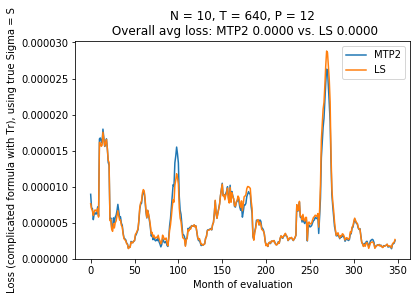

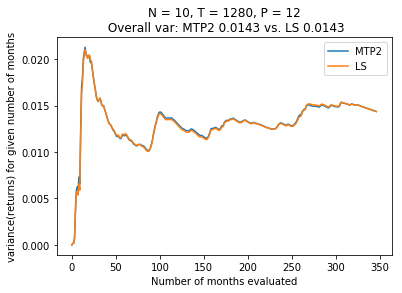

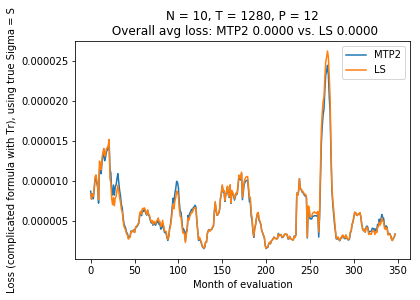

In [63]:
P = None
print_P = P
if print_P is None:
    print_P = 12

univ_nums = [1,2]

for N in Ns:
    for r in ratios:
        T = int(r * N)
        if T > 2000:
            continue
        folder = "small_N_{}_T_{}_univ_{}".format(N, T, 1)
        MTP2_rets, LS_rets = Util.load_OOS(folder, P)
        MTP2_losses, LS_losses = Util.load_losses(folder, P)
        #print("N = {}, T = {}".format(N, T))
        #print("MTP2 var {} vs. LS var {}".format(np.var(MTP2_rets), np.var(LS_rets)))
        plt.xlabel("Number of months evaluated")
        plt.ylabel("variance(returns) for given number of months")
        plt.title("N = {}, T = {}, P = {}\n Overall var: MTP2 {:.4f} vs. LS {:.4f}".format(N, T, print_P,
                                                                              float(np.var(MTP2_rets)),
                                                                              float(np.var(LS_rets))))
        plt.plot(Util.cumulative_variance(MTP2_rets), label = 'MTP2')
        plt.plot(Util.cumulative_variance(LS_rets), label = 'LS')
        plt.legend()
        plt.savefig('./figures/historical_data_small_N/variance_N_{}_T_{}_P_{}.png'.format(N, T, print_P))

        plt.show()
        
        #print("MTP2 avg loss {} vs. LS avg loss {}".format(np.mean(MTP2_losses), np.mean(LS_losses)))
        plt.xlabel("Month of evaluation")
        plt.ylabel("Loss (complicated formula with Tr), using true Sigma = S")
        plt.title("N = {}, T = {}, P = {}\n Overall avg loss: MTP2 {:.4f} vs. LS {:.4f}".format(N, T, print_P,
                                                                              float(np.mean(MTP2_losses)),
                                                                              float(np.mean(LS_losses))))
        plt.plot(MTP2_losses, label = 'MTP2')
        plt.plot(LS_losses, label = 'LS')
        plt.legend()
        plt.savefig('./figures/historical_data_small_N/loss_N_{}_T_{}_P_{}.png'.format(N, T, print_P))

        plt.show()

In [42]:
outRet = Util.get_invest_period_custom_univ(200, 36, subset, tradeidx, ret)
np.set_printoptions(precision=3)
for r in Util.cov_to_corr(np.cov(outRet.T)):
    print(r)
for r in np.linalg.inv(Util.cov_to_corr(np.cov(outRet.T))):
    print(r)

[1.    0.364 0.337 0.335 0.25  0.225 0.172 0.239 0.261 0.368]
[0.364 1.    0.427 0.422 0.381 0.333 0.153 0.278 0.357 0.428]
[0.337 0.427 1.    0.496 0.289 0.361 0.18  0.268 0.259 0.596]
[0.335 0.422 0.496 1.    0.298 0.312 0.222 0.295 0.313 0.509]
[0.25  0.381 0.289 0.298 1.    0.178 0.183 0.204 0.297 0.252]
[0.225 0.333 0.361 0.312 0.178 1.    0.134 0.161 0.1   0.353]
[0.172 0.153 0.18  0.222 0.183 0.134 1.    0.192 0.162 0.22 ]
[0.239 0.278 0.268 0.295 0.204 0.161 0.192 1.    0.236 0.282]
[0.261 0.357 0.259 0.313 0.297 0.1   0.162 0.236 1.    0.321]
[0.368 0.428 0.596 0.509 0.252 0.353 0.22  0.282 0.321 1.   ]
[ 1.29  -0.195 -0.095 -0.105 -0.08  -0.051 -0.06  -0.09  -0.094 -0.174]
[-0.195  1.581 -0.18  -0.181 -0.285 -0.219  0.039 -0.104 -0.233 -0.161]
[-9.484e-02 -1.803e-01  1.792e+00 -3.248e-01 -1.135e-01 -1.945e-01
  1.523e-03 -6.942e-02  1.312e-02 -6.788e-01]
[-0.105 -0.181 -0.325  1.616 -0.101 -0.117 -0.1   -0.127 -0.131 -0.346]
[-0.08  -0.285 -0.113 -0.101  1.263 -0.018 -0.102 -

# This is old stuff

In [19]:
subsets = pickle.load(open('./matlab/data_small_N_5/subsets.pkl', 'rb'))

In [39]:
cores = 8
for s_num, subset in enumerate(subsets):
    print(s_num)
    if s_num == 0:
        continue
    if s_num > 2:
        break
    ogcwd = os.getcwd()
    os.chdir('./matlab/data_small_N_5')

    for h in range(len(univ)):#len(univ)):
        pastRet = Util.get_past_period_custom_univ(h, T, subset, tradeidx, ret)
        S = np.cov(pastRet.T) #sample covariance
        mdict = {'S': S}
        scipy.io.savemat('subset_{}_T_{}_unividx_{}.mat'.format(s_num, T, h), mdict)

    os.chdir(ogcwd)
    print("Done with saving covariance matrices")

    commands = []
    for i, arr in enumerate(np.array_split(range(len(univ)), cores)):
        all_commands = []
        for h in arr:
            c = Util.construct_command('subset_{}_T_{}_unividx_{}.mat'.format(s_num, T, h), 
                              'out_subset_{}_T_{}_unividx_{}.mat'.format(s_num, T, h),
                              'data_small_N_5/')
            all_commands.append(c)
        commands.append(Util.construct_string_commands(all_commands))
        with Pool(cores) as p:
            p.map(Util.matlab_command_wrapper, commands)

0
1
Done with saving covariance matrices
2
Done with saving covariance matrices
3


In [ ]:
LS_results = []
for s_num, subset in enumerate(subsets):
    LS_losses = get_OOS_loss(linear_shrinkage.estimator, 
                        N, T, P, subset,
                        ret, tradeidx)
    LS_results.append(LS_losses)

In [ ]:
MTP2_results = []
for s_num, subset in enumerate(subsets):
    MTP2_losses = get_OOS_loss(
        Util.MTP2_cov_folder('./matlab/data_small_N_5', s_num, T),
        N, T, P, subset,
        ret, tradeidx, past_ret_passed = False)
    MTP2_results.append(MTP2_losses)

In [51]:
for i in range(3):
    l = LS_results[i]
    m = MTP2_results[i]
    print(np.mean(l), np.mean(m))

4.079456155550267e-05 4.104607987554649e-05
3.200251533495421e-05 3.2566986546256925e-05
1.612466406916281e-05 1.6159213443221484e-05
